#Neural Style Transfer

In [ ]:
#필요한 도구들을 불러옵니다.

import numpy as np
import pandas as pd
from PIL import Image
import requests
import os
from glob import glob
import tensorflow.keras.preprocessing.image as process_im
from pathlib import Path

from keras import backend
from keras.models import Model
from keras import backend as K

#이 모델은 VGG16을 사용하는 모델이기 때문에 VGG16을 불러옵니다.
#VGG16은 ResNet,Inception과 비교해 상대적으로 간단한 모델인 덕분에 Style Transfer를 하기 용이합니다.
from keras.applications.vgg16 import VGG16
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.optimize import fmin_l_bfgs_b

import tensorflow as tf
tf.compat.v1.disable_eager_execution()
import warnings
warnings.filterwarnings('ignore')

import cv2

In [ ]:
#이미지의 크기와 스타일, 컨텐츠의 가중치를 설정해줍니다.
#ITERATION(반복)로 loss를 줄여 더 깔끔한 이미지를 출력하게 해줍니다.

ITERATIONS = 5
CHANNELS = 3
IMAGE_WIDTH = 828
IMAGE_HEIGHT = 250
IMAGENET_MEAN_RGB_VALUES = [123.68, 116.779, 103.939]
CONTENT_WEIGHT = 0.01
STYLE_WEIGHT = 4

TOTAL_VARIATION_WEIGHT = 0.995

TOTAL_VARIATION_LOSS_FACTOR = 1.25

In [ ]:
#원본 이미지에 입혀줄 스타일 이미지의 경로를 설정해줍니다.

style_image_path = ''
combination_image = backend.placeholder((1, IMAGE_HEIGHT, IMAGE_WIDTH, 3))

# Style visualization을 통해 스타일 이미지의 크기를 저장해줍니다. 
style_image = Image.open(style_image_path)
style_image = style_image.resize((IMAGE_WIDTH, IMAGE_HEIGHT))
style_image.save(style_image_path)
# Style image에 대한 배열을 
style_image_array = np.asarray(style_image, dtype="float32")
style_image_array = np.expand_dims(style_image_array, axis=0)
style_image_array[:, :, :, 0] -= IMAGENET_MEAN_RGB_VALUES[2]
style_image_array[:, :, :, 1] -= IMAGENET_MEAN_RGB_VALUES[1]
style_image_array[:, :, :, 2] -= IMAGENET_MEAN_RGB_VALUES[0]
style_image_array = style_image_array[:, :, :, ::-1]

style_image = backend.variable(style_image_array)

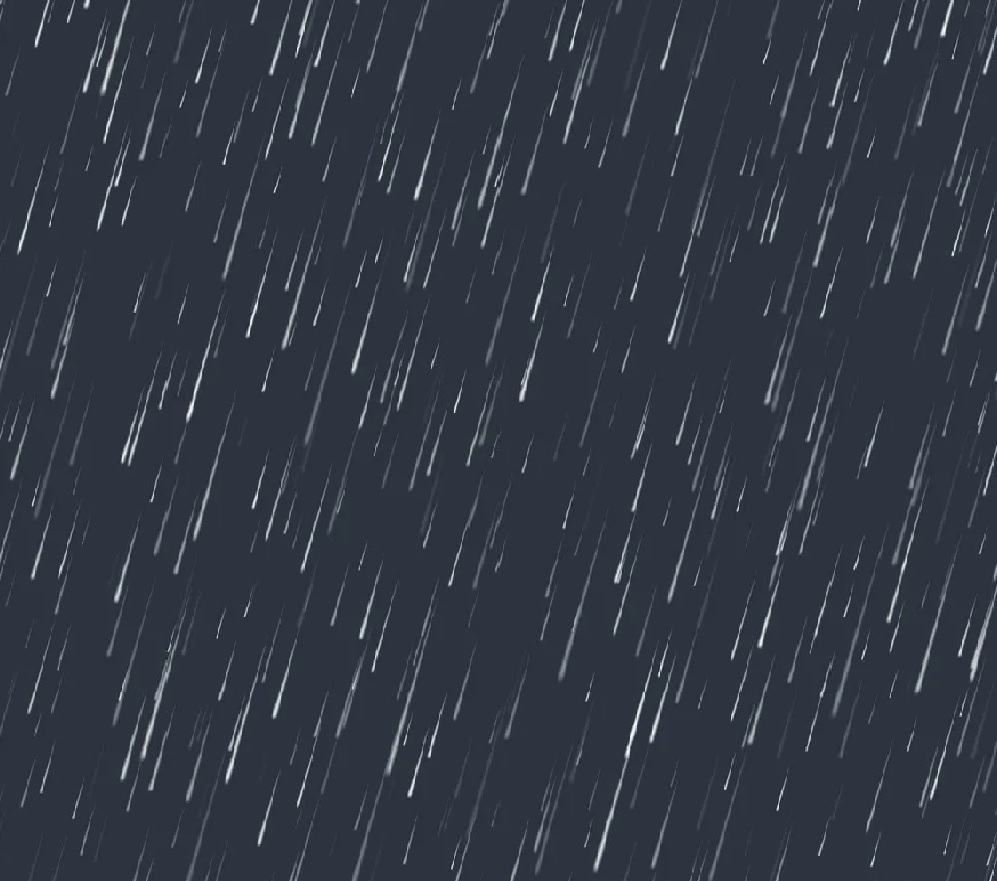

In [ ]:
def content_loss(content, combination):
    return backend.sum(backend.square(combination - content))
# combination --> white noise
# combination 과 content layer간의 RMSE를 구한다

In [ ]:
def gram_matrix(x):
    features = backend.batch_flatten(backend.permute_dimensions(x, (2, 0, 1)))
    gram = backend.dot(features, backend.transpose(features))
    return gram
# gram_matrix는 픽쳐맵마다 grid 간의 pixel 상관관계를 담은 matrix입니다.
# 이것을 사용해서 loss를 뽑은 후 경사하강법을 이용해서 white noise를 생성합니다.

In [ ]:
# style loss 
def compute_style_loss(style, combination):
    style = gram_matrix(style)
    combination = gram_matrix(combination)
    size = IMAGE_HEIGHT * IMAGE_WIDTH
    return backend.sum(backend.square(style - combination)) / (4. * (CHANNELS ** 2) * (size ** 2))

In [ ]:
def total_variation_loss(x):
    a = backend.square(x[:, :IMAGE_HEIGHT-1, :IMAGE_WIDTH-1, :] - x[:, 1:, :IMAGE_WIDTH-1, :])
    b = backend.square(x[:, :IMAGE_HEIGHT-1, :IMAGE_WIDTH-1, :] - x[:, :IMAGE_HEIGHT-1, 1:, :])
    return backend.sum(backend.pow(a + b, TOTAL_VARIATION_LOSS_FACTOR))

# variation_loss는 입력 이미지의 인접 pixel값에 대한 절대 차이의 합입니다.
# 생성된 이미지의 픽셀을 사용하여 계산하는 총 변위 손실입니다. 생산된 이미지의 공간적인 연속성을 가지게 해주며,
# 픽셀의 격자 무늬가 과도하게 나타나는 것을 방지해주는 일종의 규제입니다.
# 두 loss 함수에 하나의 loss 함수를 더 사용합니다.

In [ ]:
def evaluate_loss_and_gradients(x):
  global outputs

  x = x.reshape((1, IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS))
  outs = backend.function([combination_image], outputs)([x])
  loss = outs[0]
  gradients = outs[1].flatten().astype("float64")
    
  return loss, gradients
#성능 평가를 위한 Evaluator의 베이스 class(loss와 gradients)
class Evaluator:
#경사 하강법을 통한 손실값 최적화
    def loss(self, x):
      global loss
      loss, gradients = evaluate_loss_and_gradients(x)
      self._gradients = gradients
      return loss

    def gradients(self, x):
        return self._gradients

# loss함수와 gradient값을 따로 계산하는 것은 연산이 매우 많아져 시간이 오래 걸리기 때문에 새로운 클래스를 정의하여 시간을 단축시킵니다.


In [ ]:
#결합될 이미지의 기본 베이스가 되는 컨탠츠 이미지의 경로를 설정합니다.

content_image_path = ''

input_image_list = []

In [ ]:
def neural_style_transfer(content_image_path,output_image_path):  
    # Paths

  input_image_path = "input.jpg"
  style_image_path = "style.jpg"
  combined_image_path = "combined.jpg"

#Input visualization input 이미지와 content 이미지경로를 동일하게 맞추고 설정된 크기로 저장합니다.
  input_image = Image.open(content_image_path)
  input_image = input_image.resize((IMAGE_WIDTH, IMAGE_HEIGHT))
  input_image.save(input_image_path)


  # Data normalization and reshaping from RGB to BGR 컨텐츠 이미지에 대한 어레이를 진행합니다.
  input_image_array = np.asarray(input_image, dtype="float32")
  input_image_array = np.expand_dims(input_image_array, axis=0)
  input_image_array[:, :, :, 0] -= IMAGENET_MEAN_RGB_VALUES[2]
  input_image_array[:, :, :, 1] -= IMAGENET_MEAN_RGB_VALUES[1]
  input_image_array[:, :, :, 2] -= IMAGENET_MEAN_RGB_VALUES[0]
  input_image_array = input_image_array[:, :, :, ::-1]


# Model 
  input_image = backend.variable(input_image_array)
  

  input_tensor = backend.concatenate([input_image,style_image,combination_image], axis=0)
  model = VGG16(input_tensor=input_tensor, include_top=False)

  layers = dict([(layer.name, layer.output) for layer in model.layers])

  content_layer = "block2_conv2"
  layer_features = layers[content_layer]
  content_image_features = layer_features[0, :, :, :]
  combination_features = layer_features[2, :, :, :]

  loss = backend.variable(0.)
  loss = loss + CONTENT_WEIGHT * content_loss(content_image_features,
                                        combination_features)
  
  style_layers = ["block1_conv2", "block2_conv2", "block3_conv3", "block4_conv3", "block5_conv3"]
  for layer_name in style_layers:
    layer_features = layers[layer_name]
    style_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    style_loss = compute_style_loss(style_features, combination_features)
    loss = loss + (STYLE_WEIGHT / len(style_layers)) * style_loss
  
  
  loss = loss + TOTAL_VARIATION_WEIGHT * total_variation_loss(combination_image)
  global outputs
  outputs = [loss]
  outputs = outputs + backend.gradients(loss, combination_image) 

  evaluator = Evaluator()

  x = np.random.uniform(0, 255, (1, IMAGE_HEIGHT, IMAGE_WIDTH, 3)) - 128.

  for i in range(ITERATIONS):
    x, loss, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(), fprime=evaluator.gradients, maxfun=20)
    print("Iteration %d completed with loss %d" % (i, loss))
    
  x = x.reshape((IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS))
  x = x[:, :, ::-1]
  x[:, :, 0] += IMAGENET_MEAN_RGB_VALUES[2]
  x[:, :, 1] += IMAGENET_MEAN_RGB_VALUES[1]
  x[:, :, 2] += IMAGENET_MEAN_RGB_VALUES[0]
  x = np.clip(x, 0, 255).astype("uint8")
  output_image = Image.fromarray(x)
  output_image.save(output_image_path)

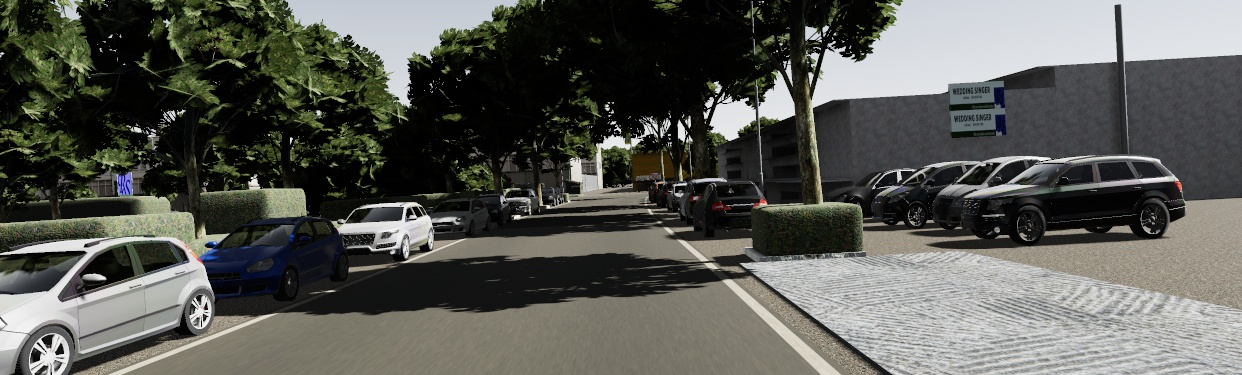

In [ ]:
# 폴더 내의 이미지들을 순차적으로 돌리기 위해 경로와 조합된 이미지를 저장할 경로를 선정해준다
DIR_IN = ''
save_path = ''

#file_list = os.listdir(DIR_IN)
#for file in file_list:          # 코드간결화 작업전
    #if file.endswith(".jpg"):

# 폴더 내 파일의 범위를 지정해서 범위 안 파일만 변환을 시켜준다.       
for i in range(,):
  neural_style_transfer(DIR_IN+'rgb_'+str(i).zfill(5)+'.jpg', save_path+'rgb_'+str(i).zfill(5)+'.jpg')

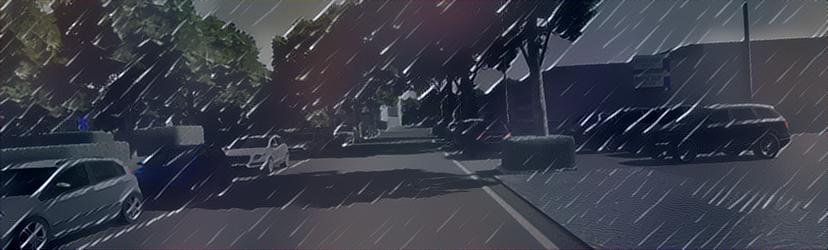

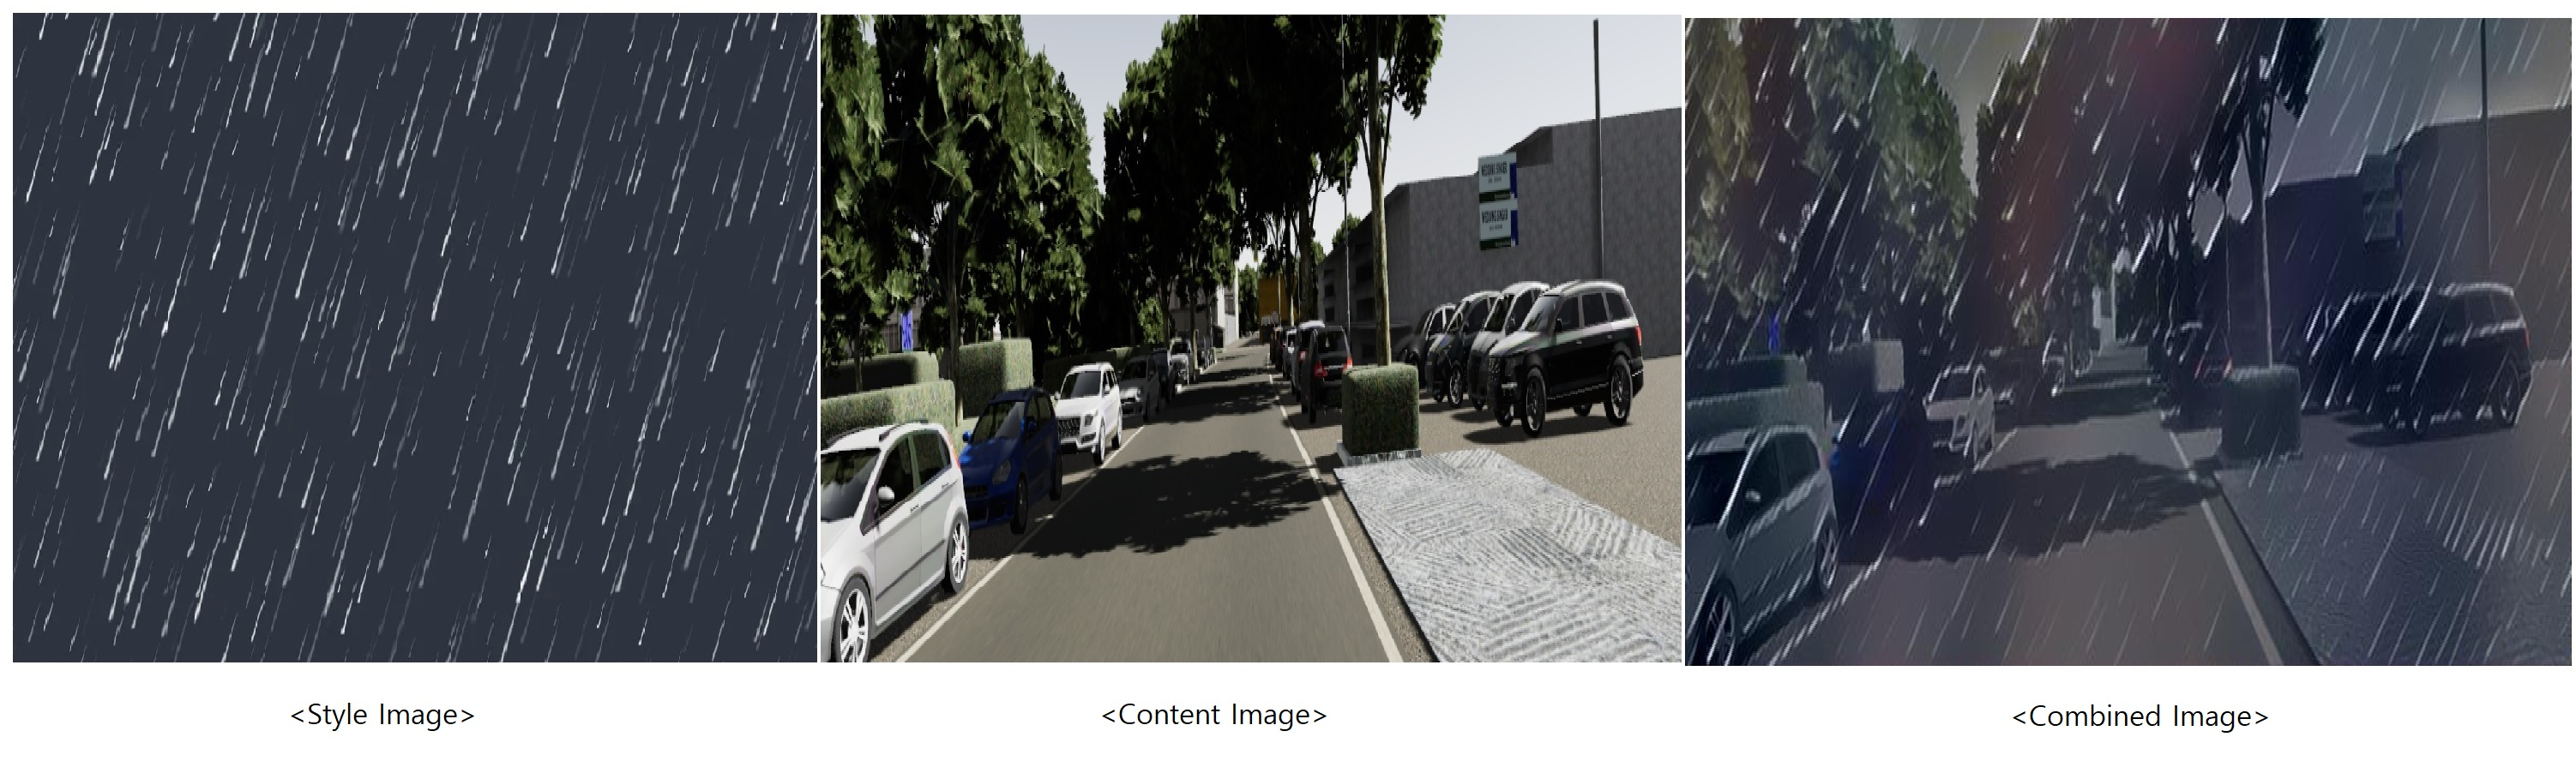